# TUGAS KEDUA: Pengembangan Machine Learning (DICODING)

<a href = 'https://www.linkedin.com/in/louis-widi-anandaputra-90008815a/' target = 'blank'> Louis Widi Anandaputra </a>

## Membuat Model Machine Learning dengan Data Time Series

- Dataset yang akan dipakai bebas, namun minimal memiliki 1000 sampel.
- Harus menggunakan LSTM dalam arsitektur model.
- Validation set sebesar 20% dari total dataset.
- Model harus menggunakan model sequential.
- Harus menggunakan Learning Rate pada Optimizer.
- MAE < 10% skala data.

## Persiapan Library dan Fungsi

In [1]:
# Library standard
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Library untuk statistical decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Library untuk proses machine learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.callbacks import EarlyStopping
import tensorflow as tf

# Fungsi untuk pesiapan data
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

Data yang digunakan berasal dari <a href='https://www.kaggle.com/datasets/rohanrao/air-quality-data-in-india' target = 'blank'>Kaggle</a>, yakni data kualitas udara yang dukumpulkan dari beberapa stasiun pengukuran di India. 
<a href='https://www.kaggle.com/datasets/rohanrao/air-quality-data-in-india' target = 'blank'><img src = 'image.png'></a>



Projek ini akan mencoba untuk memprediksi Air Quality Index (AQI) yang didapat pada stasiun pengukuran tertentu. Salah satu tantangan yang terdapat pada projek ini adalah proses yang akan mencoba memprediksi lebih dari 3000 data, dimana data tidak terdistribusi secara normal, menjadikan sebuah tantangan tersendiri bagi model deep learning yang akan digunakan untuk mencari fitur dan pola yang dapat digunakna untuk memprediksi nilai AQI.
<img src = 'https://www.deq.ok.gov/wp-content/uploads/air-division/aqi_mini.png'>

## Pre-Processing Data dan Pemilihan Stasiun Pengukuran

In [2]:
# Import data
df = pd.read_csv('dataset/station_hour.csv')
# Formating kolom waktu
df['Datetime'] = pd.to_datetime(df['Datetime'])
# Mencari stasiun pengukuran yang akan digunakan
df['StationId'].unique()

/var/folders/kp/1yj5j5nx6gddj5pqbjbnl45r0000gn/T/ipykernel_10595/1249998497.py:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('dataset/station_hour.csv')


array(['AP001', 'AP005', 'AS001', 'BR005', 'BR006', 'BR007', 'BR008',
       'BR009', 'BR010', 'CH001', 'DL001', 'DL002', 'DL003', 'DL004',
       'DL005', 'DL006', 'DL007', 'DL008', 'DL009', 'DL010', 'DL011',
       'DL012', 'DL013', 'DL014', 'DL015', 'DL016', 'DL017', 'DL018',
       'DL019', 'DL020', 'DL021', 'DL022', 'DL023', 'DL024', 'DL025',
       'DL026', 'DL027', 'DL028', 'DL029', 'DL030', 'DL031', 'DL032',
       'DL033', 'DL034', 'DL035', 'DL036', 'DL037', 'DL038', 'GJ001',
       'HR011', 'HR012', 'HR013', 'HR014', 'JH001', 'KA002', 'KA003',
       'KA004', 'KA005', 'KA006', 'KA007', 'KA008', 'KA009', 'KA010',
       'KA011', 'KL002', 'KL004', 'KL007', 'KL008', 'MH005', 'MH006',
       'MH007', 'MH008', 'MH009', 'MH010', 'MH011', 'MH012', 'MH013',
       'MH014', 'ML001', 'MP001', 'MZ001', 'OD001', 'OD002', 'PB001',
       'RJ004', 'RJ005', 'RJ006', 'TG001', 'TG002', 'TG003', 'TG004',
       'TG005', 'TG006', 'TN001', 'TN002', 'TN003', 'TN004', 'TN005',
       'UP012', 'UP0

Stasiun pengukuran yang dipilih merupakan TG004

In [3]:
# Pemilihan data
main_data = df[df['StationId']=='TG003']
main_data = main_data[['Datetime', 'AQI']]
# Penghilangan data kosong
main_data.dropna(inplace = True)
main_data

,Datetime,AQI
2050772,2017-02-17 07:00:00,225.0
2050773,2017-02-17 08:00:00,235.0
2050774,2017-02-17 09:00:00,243.0
2050775,2017-02-17 10:00:00,248.0
2050776,2017-02-17 11:00:00,241.0
...,...,...
2080281,2020-06-30 20:00:00,41.0
2080282,2020-06-30 21:00:00,40.0
2080283,2020-06-30 22:00:00,40.0
2080284,2020-06-30 23:00:00,40.0


Stasiun yang dipilih merupakan stasiun TG003 dan terdapat total 28.369 data yang bukan nilai kosong (np.nan)

## EDA dan Data Engineering

Text(0, 0.5, 'AQI')

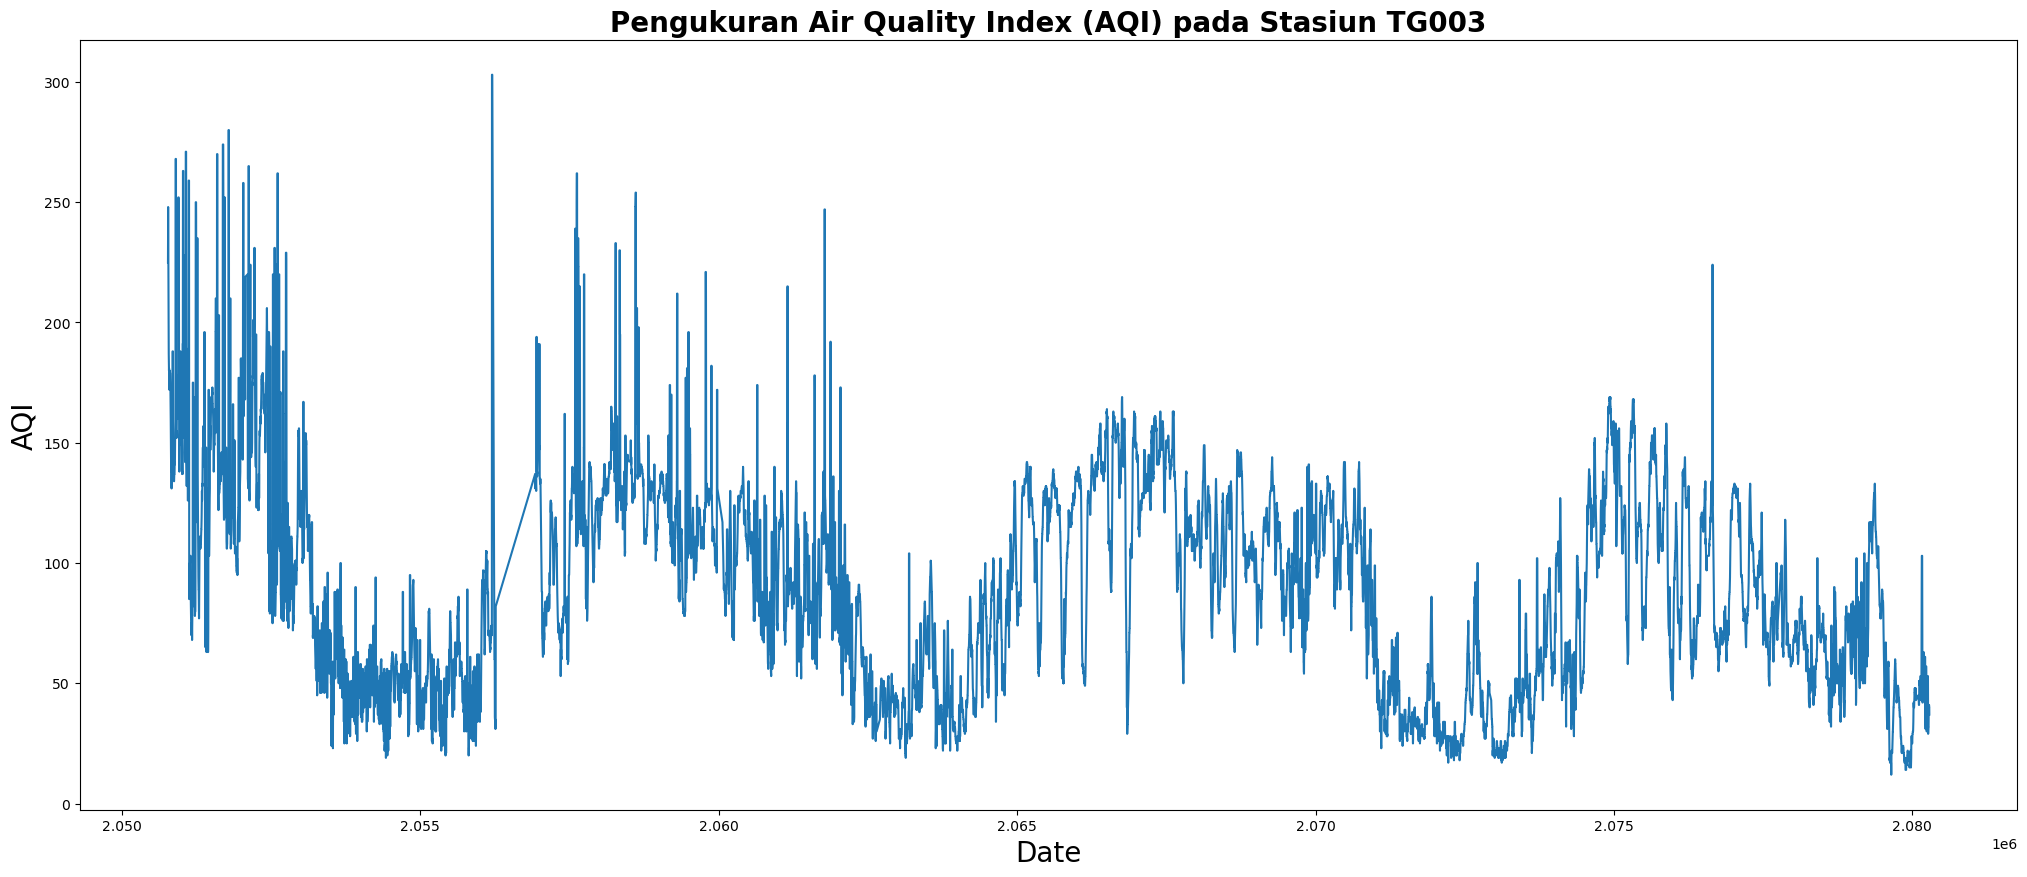

In [4]:
plt.subplots(figsize=(25,10))
sns.lineplot(data = main_data['AQI'])
plt.title("Pengukuran Air Quality Index (AQI) pada Stasiun TG003", fontsize = 20, weight = 'bold')
plt.xlabel('Date',fontsize = 20)
plt.ylabel('AQI',fontsize = 20)

In [5]:
main_data.set_index('Datetime', inplace = True)

/var/folders/kp/1yj5j5nx6gddj5pqbjbnl45r0000gn/T/ipykernel_10595/2636161573.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


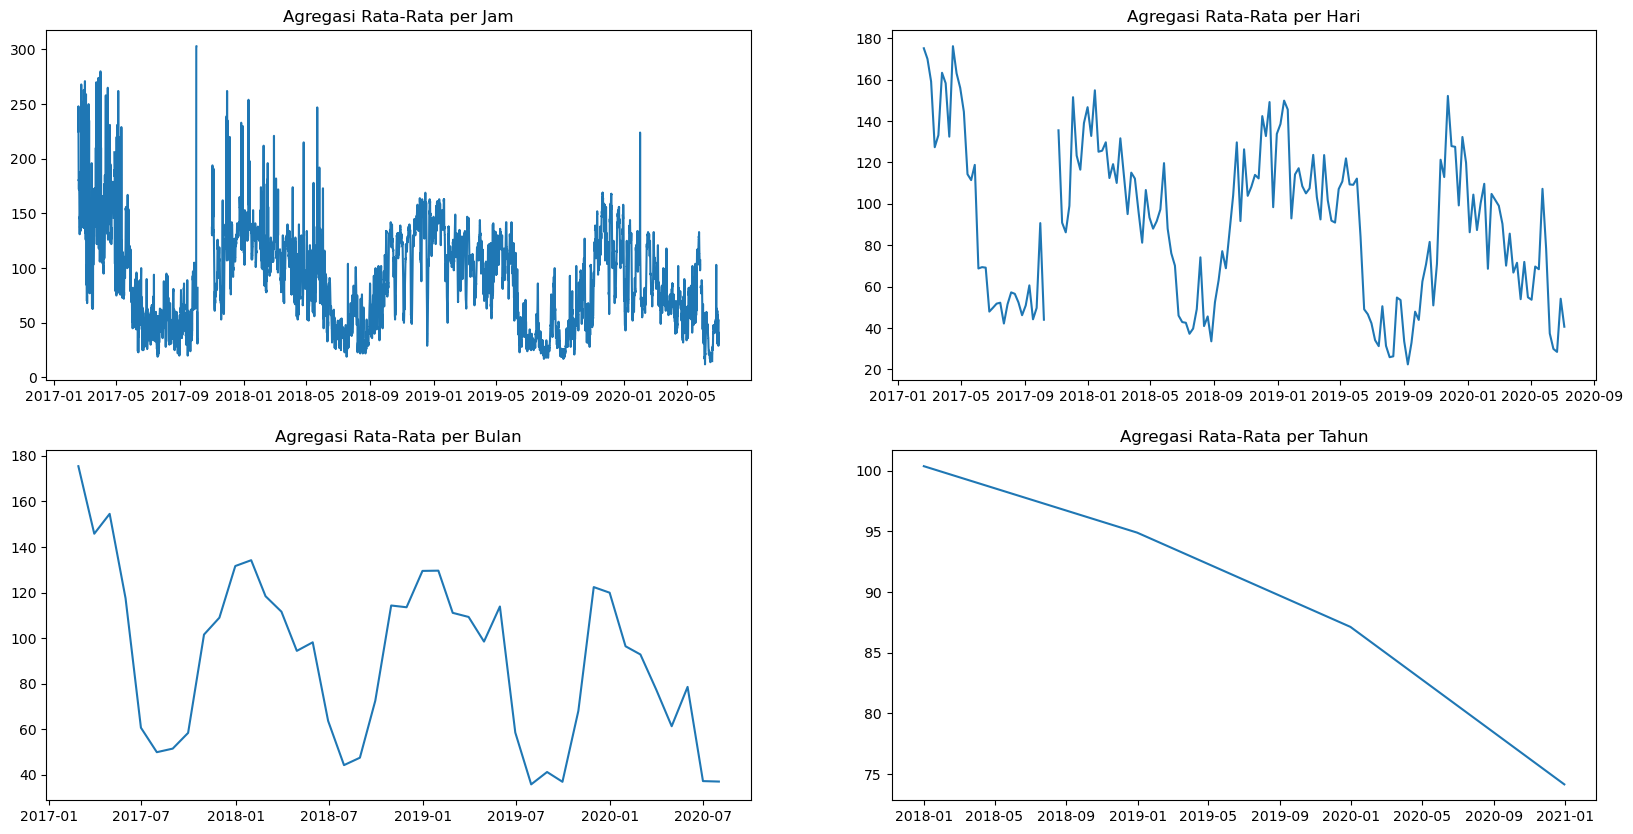

In [6]:
# Evaluasi pada setiap agregasi data

hourly_aggregated = main_data['AQI'].resample('H').mean()
weekly_aggregated = main_data['AQI'].resample('W').mean()
monthly_aggregated = main_data['AQI'].resample('M').mean()
yearly_aggregated = main_data['AQI'].resample('Y').mean()

fig,ax = plt.subplots(ncols = 2, nrows = 2,figsize=(20, 10))
ax[0][0].plot(hourly_aggregated, label='Hourly')
ax[0][0].set_title("Agregasi Rata-Rata per Jam")
ax[0][1].plot(weekly_aggregated, label='Weekly')
ax[0][1].set_title("Agregasi Rata-Rata per Hari")
ax[1][0].plot(monthly_aggregated, label='Monthly')
ax[1][0].set_title("Agregasi Rata-Rata per Bulan")
ax[1][1].plot(yearly_aggregated, label='Yearly')
ax[1][1].set_title("Agregasi Rata-Rata per Tahun")
fig.show()

In [7]:
# Menghilangkan missing value pada hasil agregasi
hourly_aggregated.dropna(inplace = True)
hourly_aggregated.isnull().sum()

0

In [8]:
# Seasonal Decomposition
result = seasonal_decompose(x = hourly_aggregated, model='additive', period=24)  

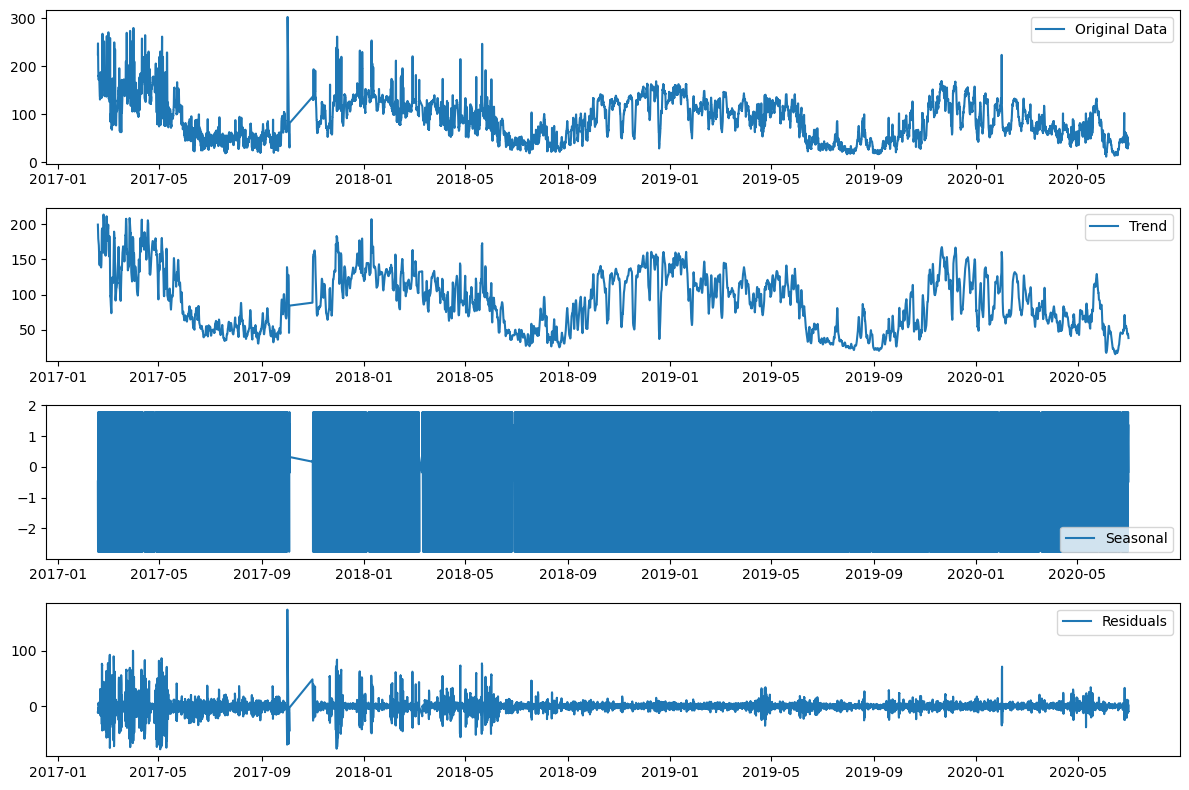

In [9]:
plt.figure(figsize=(12, 8))

# Original Data
plt.subplot(4, 1, 1)
plt.plot(hourly_aggregated, label='Original Data')
plt.legend()

# Trend Component
plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend')
plt.legend()

# Seasonal Component
plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonal')
plt.legend()

# Residuals
plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residuals')
plt.legend()

plt.tight_layout()
plt.show()

Melalui Seasonal Decomposition, data yang memiliki nilai fluktuasi kecil yang dilihat melalui residual merupakan data setelah bulan Januari 2018 (2018-01). Sehingga, akan dilakukan pemotongan data agar data yang digunakan berasal dari timeframe tersebut.

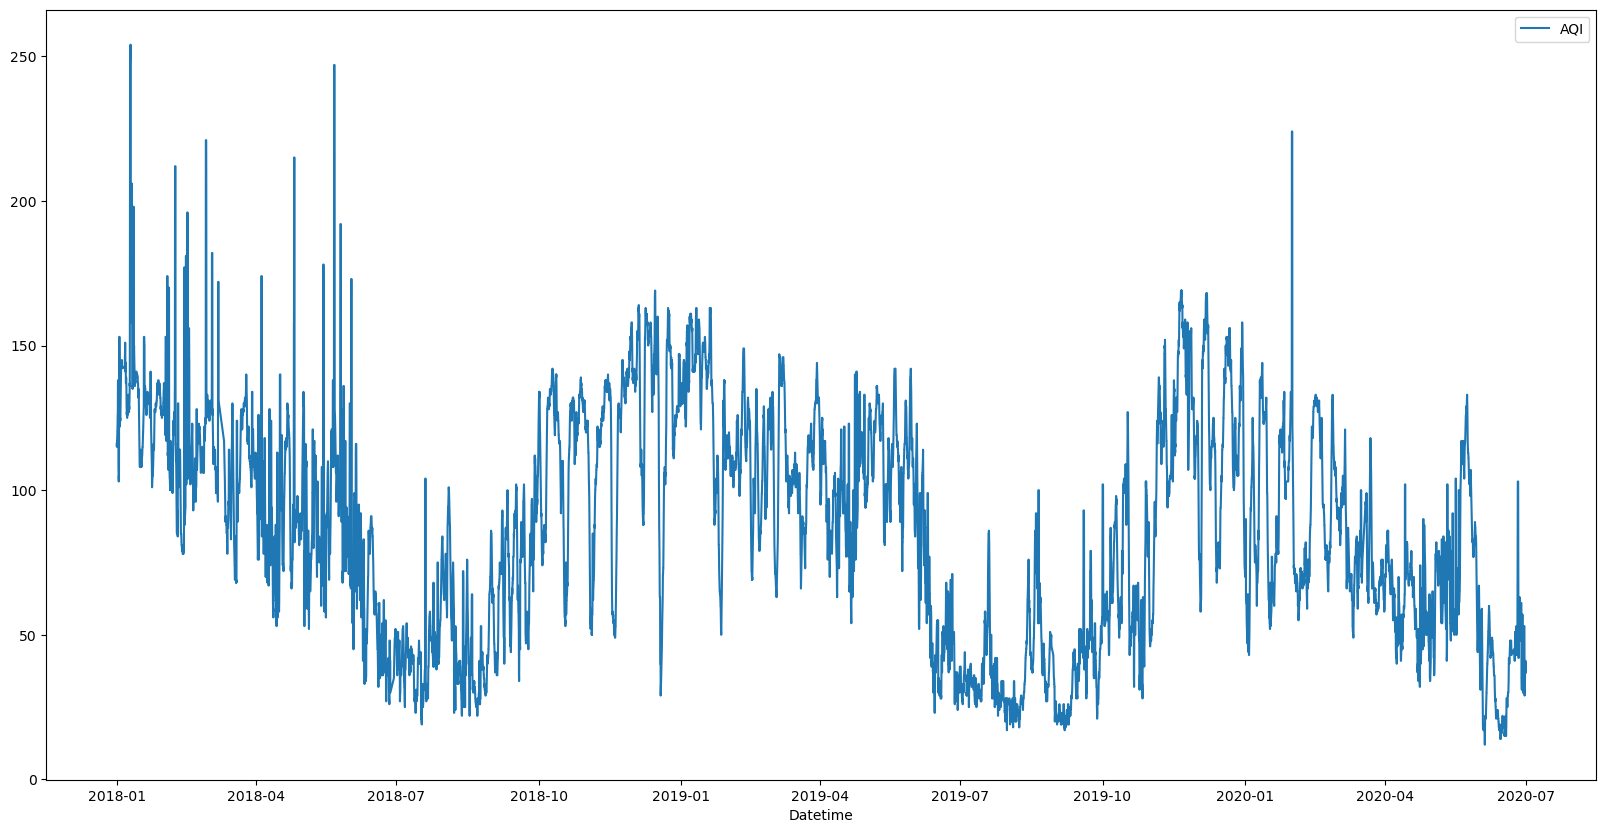

Panjang Data yang akan Digunakan: 21500


In [10]:
main_data = main_data['2018-01-01':]
plt.figure(figsize = (20, 10))
sns.lineplot(data = main_data)
plt.show()
print("Panjang Data yang akan Digunakan: " + str(len(main_data)))

Dengan panjang data yang lebih dari 21,000, akan menjadi suatu tantangan ketika memprediksi sekitar 4000 (0.2 dari 21,000) data baru, mengingat time series prediction yang dilakukan pada projek ini merupakan prediksi berbasis 1 fitur saja.

## Persiapan Training

In [11]:
# Train-test split 20%
train, test = train_test_split(main_data.values, test_size=0.2, shuffle=False)

In [12]:
# Persiapan min-max scaler
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(main_data)

MinMaxScaler()

In [13]:
# Scaling data 
train_scaled = min_max_scaler.transform(train.reshape(-1, 1))
test_scaled = min_max_scaler.transform(test.reshape(-1, 1))

/Users/widss/miniforge3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/widss/miniforge3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [14]:
# Persiapan data agar dapat diproses oleh model
# Window size (dapat diganti sesuai kebutuhan dan tipe data)
look_back = 48

# Penggunaan fungsi Windowed Dataset
train_set = windowed_dataset(train_scaled, window_size = look_back, batch_size = 100, shuffle_buffer=10)     
test_set = windowed_dataset(test_scaled, window_size = look_back, batch_size = 10, shuffle_buffer=1)

Metal device set to: Apple M1


In [15]:
# Penyusunan arsitektur model
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(120, return_sequences=True, input_shape=(look_back, 1)),
    tf.keras.layers.LSTM(60),
    tf.keras.layers.Dense(64, activation = "relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation = "relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation = "relu"),
    tf.keras.layers.Dense(1, activation = 'relu'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 48, 120)           58560     
                                                                 
 lstm_1 (LSTM)               (None, 60)                43440     
                                                                 
 dense (Dense)               (None, 64)                3904      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                5

In [16]:
# Penggunaan optimizer adam
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001) # Nilai Learing Rate kecil
callback = EarlyStopping(
    monitor="loss",
    patience = 10
)
# Compile dan Fitting model
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=50, callbacks = callback)

Epoch 1/50
172/172 [==============================] - 6s 28ms/step - loss: 0.0603 - mae: 0.3052
Epoch 2/50
172/172 [==============================] - 4s 26ms/step - loss: 0.0384 - mae: 0.2293
Epoch 3/50
172/172 [==============================] - 5s 28ms/step - loss: 0.0239 - mae: 0.1719
Epoch 4/50
172/172 [==============================] - 5s 28ms/step - loss: 0.0204 - mae: 0.1568
Epoch 5/50
172/172 [==============================] - 5s 27ms/step - loss: 0.0187 - mae: 0.1493
Epoch 6/50
172/172 [==============================] - 5s 26ms/step - loss: 0.0173 - mae: 0.1428
Epoch 7/50
172/172 [==============================] - 5s 26ms/step - loss: 0.0162 - mae: 0.1372
Epoch 8/50
172/172 [==============================] - 4s 26ms/step - loss: 0.0153 - mae: 0.1325
Epoch 9/50
172/172 [==============================] - 5s 26ms/step - loss: 0.0145 - mae: 0.1282
Epoch 10/50
172/172 [==============================] - 4s 26ms/step - loss: 0.0138 - mae: 0.1250
Epoch 11/50
172/172 [==================

## Evaluasi Hasil Training

In [17]:
# Persiapan tanggal untuk plotting
tanggal_train = main_data.index[:int((1-0.2)*len(main_data))]
tanggal_test = main_data.index[int((1-0.2)*len(main_data)):]

In [18]:
# Prediksi Data Baru
pred = min_max_scaler.inverse_transform(model.predict(test_set))

426/426 [==============================] - 5s 12ms/step


In [21]:
# MAE hasil prediksi vs data asli
pred_mae = round(metrics.mean_absolute_error(main_data['AQI'][int((1-0.2)*len(main_data))+look_back:],pred), 1)

# Threshold 10% pada data testing
threshold_mae = round((main_data['AQI'][int((1-0.2)*len(main_data))+look_back:].max() 
                 - main_data['AQI'][int((1-0.2)*len(main_data))+look_back:].min()) * 10/100, 1)

print("Predicted MAE: " + str(pred_mae) 
      + "\nThreshold : " + str(threshold_mae))

Predicted MAE: 13.4
Threshold : 21.2


Data prediksi memiliki nilai MAE yang jauh lebih rendah dibandingkan dengan threshold 10% selisih perbedaan nilai maksimal dan minimal pada data testing. Hal ini menjadi suatu indikasi bahwa model dapat memprediksi data AQI dengan baik.

/var/folders/kp/1yj5j5nx6gddj5pqbjbnl45r0000gn/T/ipykernel_10595/4117825301.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


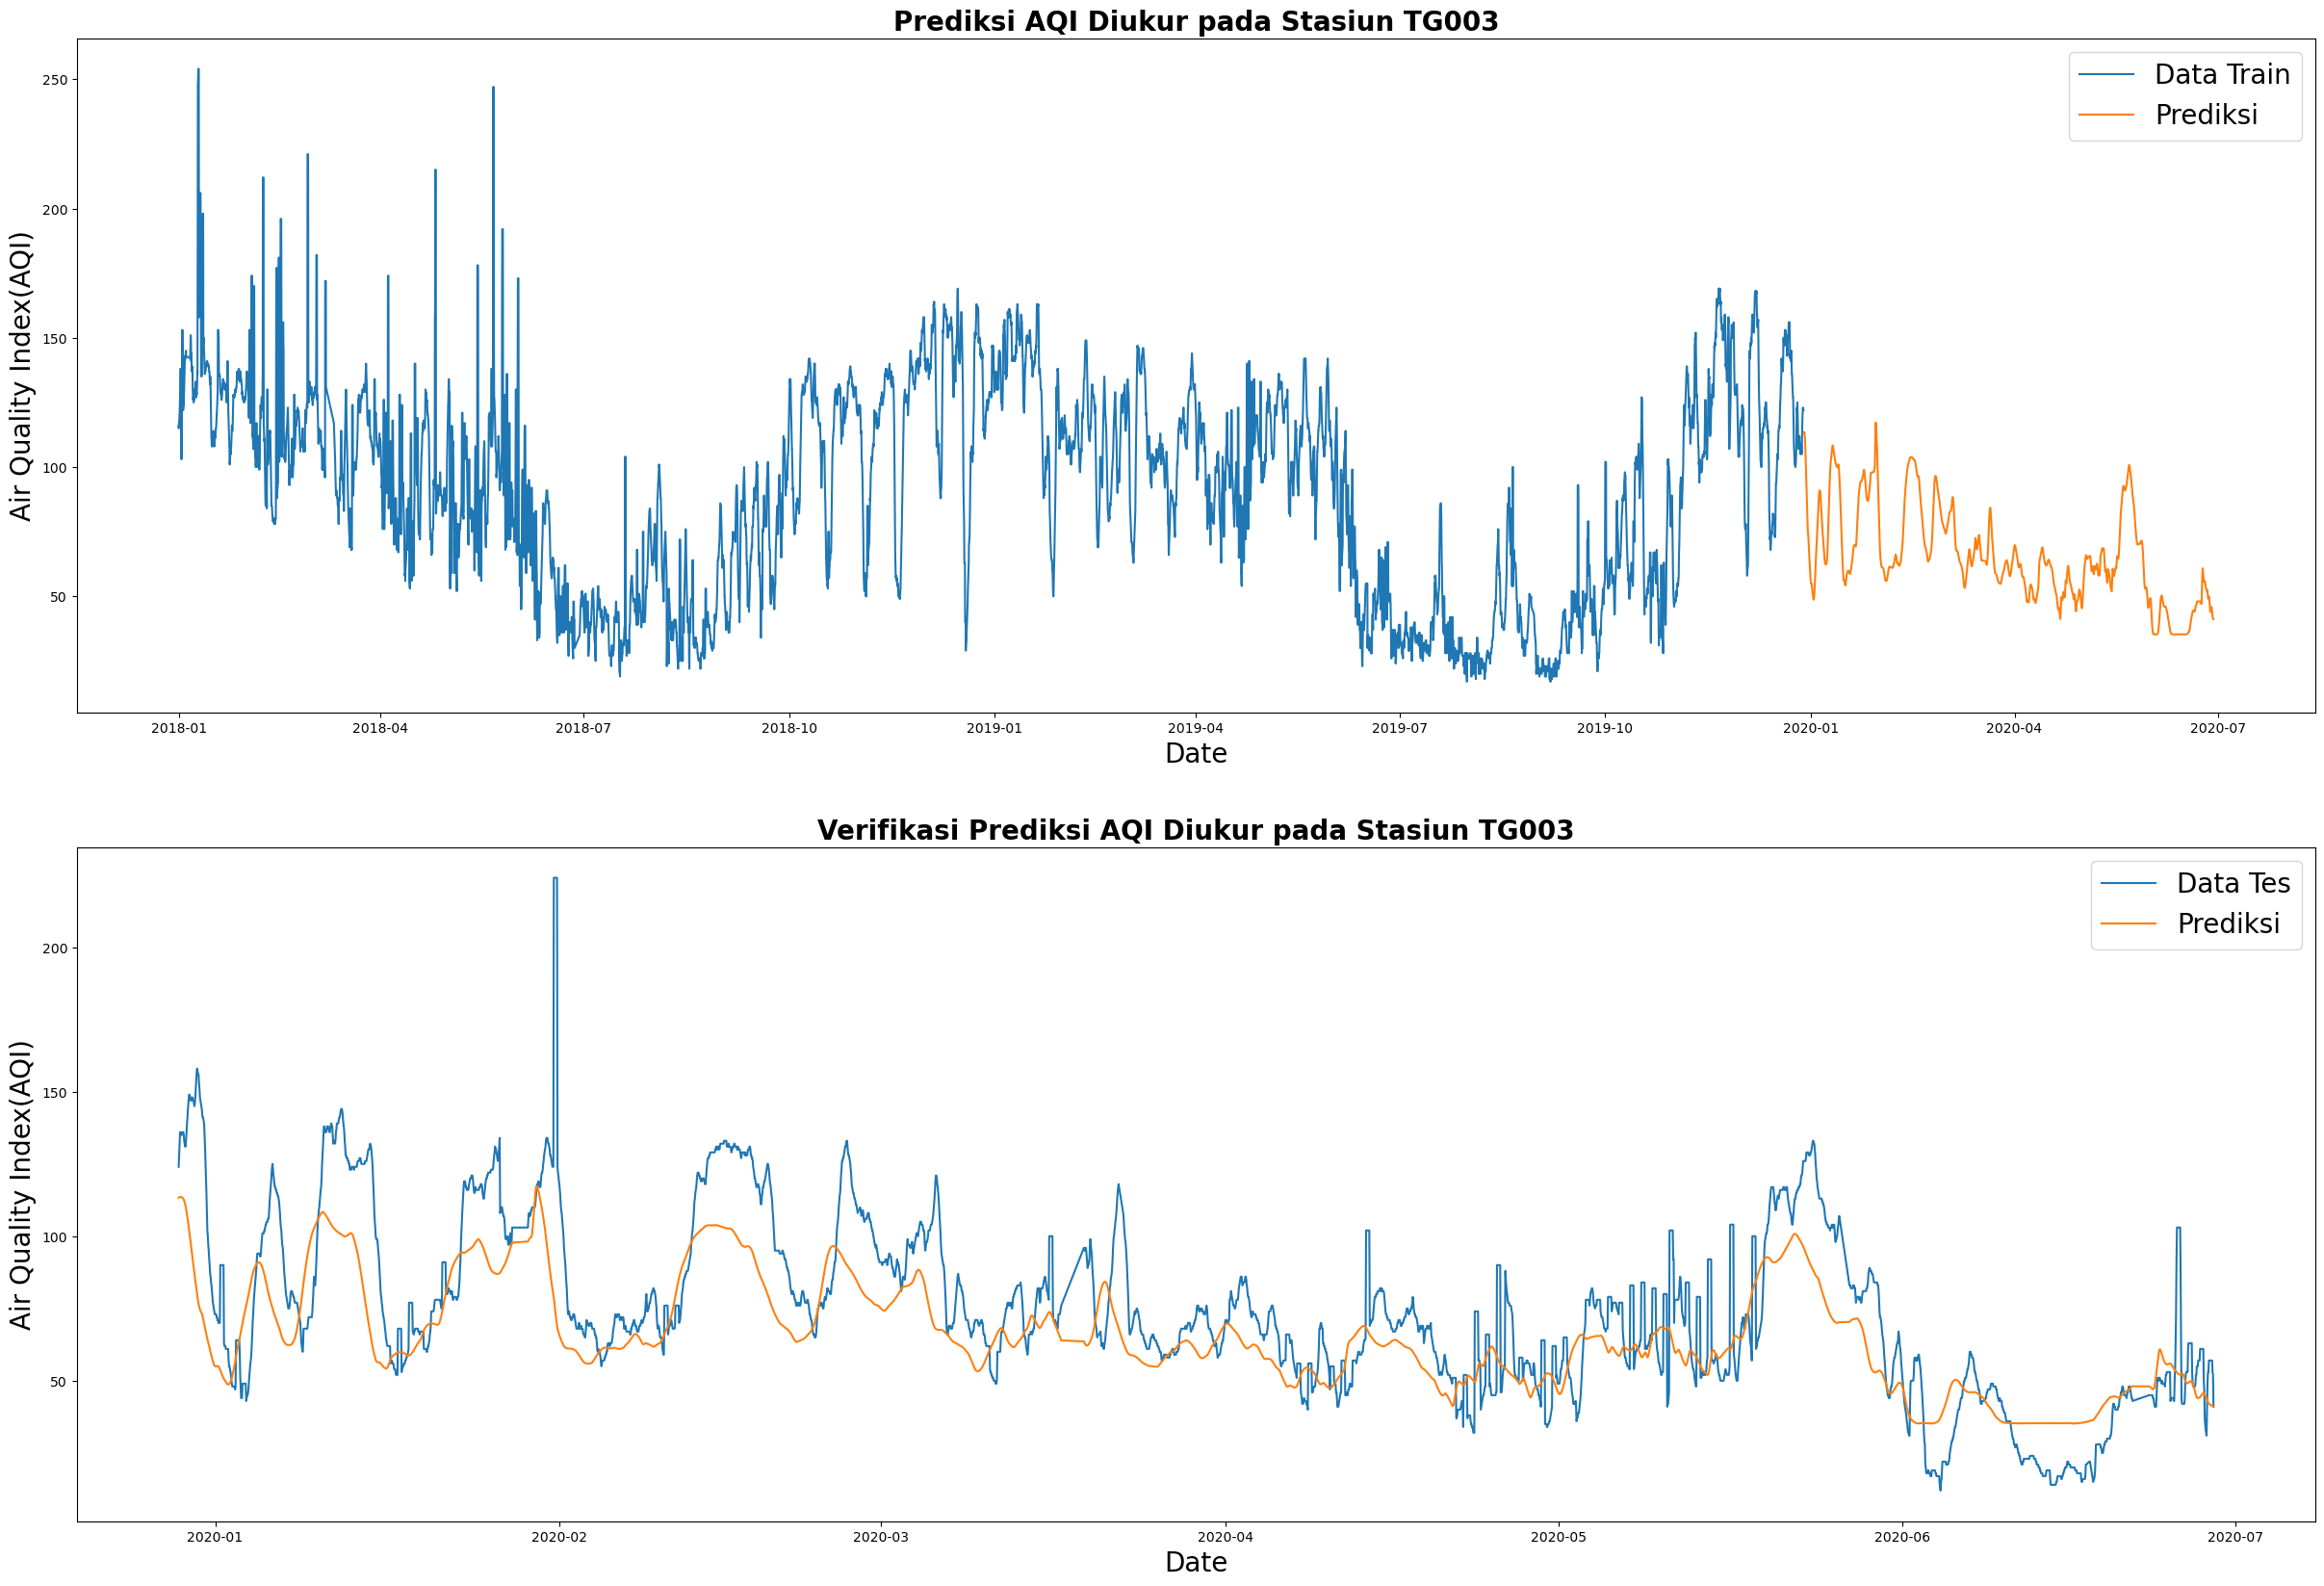

In [20]:
fig,ax = plt.subplots(nrows = 2,figsize = (30,20))
# Plot Hasil Prediksi pada Data Train
ax[0].plot(tanggal_train, train, label = "Data Train")
ax[0].plot(tanggal_test[:-look_back], pred, label = "Prediksi")
ax[0].set_title('Prediksi AQI Diukur pada Stasiun TG003', fontsize = 20, weight = 'bold')
ax[0].set_xlabel('Date', fontsize = 20)
ax[0].set_ylabel('Air Quality Index(AQI)', fontsize = 20)
ax[0].legend(fontsize = 20)

# Plot Hasil Verifkasi Prediksi pada Data Tes
ax[1].plot(tanggal_test[:-look_back], test.reshape(-1)[:-look_back], label = "Data Tes")
ax[1].plot(tanggal_test[:-look_back], pred, label = "Prediksi")
ax[1].set_title('Verifikasi Prediksi AQI Diukur pada Stasiun TG003', fontsize = 20, weight = 'bold')
ax[1].set_xlabel('Date', fontsize = 20)
ax[1].set_ylabel('Air Quality Index(AQI)', fontsize = 20)
ax[1].legend(fontsize = 20)

fig.show()

Menggunakan window size sebesar 48, model deep learning yang memiliki 2 lstm layer pada arsitekturnya dapat mencari pola dengan baik terhadap data, ditunjukkan dengan nilai MAE sebesar 13.1, yang lebih rendah dari 10% selisih data maximal dan minimal, menjadikan indikasi bahwa model dapat bekerja dengan baik. Hal ini juga didukung oleh grafik hasil evaluasi yang menunjukkan bahwa data prediksi memiliki pola yang sama dengan data asli. 

Seperti yang disampaikan pada awal notebook ini, tantangan tersendiri merupakan jumlah data yang harus diprediksi, yakni lebih dari 3000. Jumlah data tersebut menjadikan model tidak dapat memprediksi data yang memiliki nilai tinggi seperti pada grafik verifikasi di bulan Februari tahun 2020. Prediksi jangka panjang akan baik jika data yang digunakan memiliki distribusi normal, sehingga model dapat mencari pola dan fitur yang sesuai untuk melakukan prediksi dengan optimal.

© Louis Widi Anandaputra - 2023